In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle
import gc

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [4]:
class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()
    
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x

In [7]:

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        # the window size represents how many samples to include in each window
        self.window_size = window_size
        # the stride represents how many samples to skip between windows
        self.stride = stride
        
        
        # make sure the df is ordered by subject
        self.df = self.df.sort_values(by=sort_column)
        self.df = self.df.reset_index(drop=True)
        self.subject_index = [i.values for i in self.df.groupby(sort_column).apply(lambda x: x.index)]
        self.subjects = list(self.df.groupby(sort_column).groups.keys())
        self.n_features = len(xcols)
        # sort the subject list index. self.subjects contains a list of indices for that belong to each subject. lets sort each list in ascending order
        # for each subject multiple trails are run. lets split them up and make a list of lists for each subject. The way we know a 
        # new event has started is when the time column resets to its minimum value.
        
        
        
        # split the subject index into events
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # reorganize the dataframe in the order of subject_events
        self.df = pd.concat([pd.concat([self.df.loc[subject] for subject in event]) for event in self.subject_events])
        self.df = self.df.reset_index(drop=True)
        
        
        # remake subjects_events to be consistent with the new dataframe
        self.subject_events = []
        time_splits = []
        for subject in self.subject_index:
            # get the time column for the subject
            time = self.df.loc[subject]['Time'].values
            # get the indices where the time resets to its minimum value
            time_splits.append(np.where(time == time.min())[0])
            # split the subject index into events
            self.subject_events.append(np.split(subject, time_splits[-1]))
        # get rid of the empty lists in the list of lists
        self.subject_events = [[i for i in subject if len(i) > 0][0] for subject in self.subject_events]
        
        # for each subject we need to create a vector containig the indices for each window
        self.subject_windows = []
        for subject in self.subject_events:
            # get the number of windows for the subject
            n_windows = (len(subject) - self.window_size) // self.stride + 1
            # create a list of lists for the subject
            self.subject_windows.append([subject[i*self.stride:i*self.stride+self.window_size] for i in range(n_windows)])
        # get rid of the empty lists in the list of lists
        self.subject_windows = [[i for i in subject if len(i) > 0] for subject in self.subject_windows]
        # we should now be able to access the dataframe referencing the n-th frame of any subject using the __getitem__ method
        #self.subject_windows = np.concatenate(self.subject_windows)
        # reorganize self.subject_windows to be a single list of lists
        self.subject_windows = [i for subject in self.subject_windows for i in subject]
        # organize X for an LSTM model. The LSTM model expects the input to be in the shape (batch_size, seq_len, n_inputs)
        self.X = np.array([self.df.loc[window][self.xcols].values for window in self.subject_windows])
        self.X = self.X.reshape(-1, self.window_size, self.n_features)
        self.X = torch.from_numpy(self.X).float()
        
        # get the output
        self.Y = np.array([self.df.loc[window][self.ycols].values for window in self.subject_windows])
        self.Y  = torch.from_numpy(self.Y).float()
        self.Y = self.Y.view(self.X.shape[0], -1)
        self.X = self.X.to('cuda')
        self.Y = self.Y.to('cuda')
        return 
        
    
        
    def __getitem__(self, index):
        # the index is the index of the window in the subject_windows lis
        return self.df.loc[self.subject_windows[index]][self.xcols].values, self.df.loc[self.subject_windows[index]][self.ycols].values
    
    def __len__(self):
        return len(self.subject_index)

In [6]:
df = pd.read_pickle('../data/SeparatedData.pkl')
window_size = 100
stride = 20
df

,Time,Event,EPB,EPL,FPL,APL,ADD,FCU,FPB,OPP,Fx,Fy,Fz,Subject
0,0.000000,0,0.275778,0.130877,0.259917,0.415720,0.393124,0.086238,0.326176,0.276362,-0.195990,-0.366495,0.366495,bXa12
1,0.024631,0,0.350735,0.174562,0.320056,0.519087,0.474499,0.105218,0.391419,0.336600,-0.187540,-0.370361,0.370361,bXa12
2,0.049261,0,0.423366,0.220146,0.376731,0.618285,0.553137,0.123384,0.446157,0.393581,-0.176207,-0.398903,0.398903,bXa12
3,0.073892,0,0.488246,0.264673,0.426281,0.706193,0.623953,0.139146,0.485146,0.444069,-0.189739,-0.391285,0.391285,bXa12
4,0.098522,0,0.540696,0.305161,0.465857,0.776670,0.682461,0.151131,0.504956,0.485752,-0.185666,-0.356704,0.356704,bXa12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4.901151,2,0.154793,0.549888,0.560920,0.840885,0.638824,0.114369,0.532298,0.433316,-11.387135,-67.483305,67.483305,zNu44
608,4.925780,2,0.153455,0.543795,0.557760,0.832413,0.630344,0.121394,0.533150,0.442089,-11.355251,-67.445019,67.445019,zNu44
609,4.950409,2,0.153275,0.540690,0.554720,0.823159,0.630506,0.126728,0.541270,0.453512,-11.363783,-67.451038,67.451038,zNu44
610,4.975038,2,0.154321,0.541644,0.552276,0.814551,0.638750,0.128939,0.556482,0.466568,-11.271886,-67.532919,67.532919,zNu44


In [10]:
leave_out_df = df[df['Subject'] == 'RGr10']
train_df = df[df['Subject'] != 'RGr10']
train_data = Dataset_LSTM(train_df, window_size=100, stride=5)
test_data = Dataset_LSTM(leave_out_df, window_size=100, stride=5)

In [139]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))

<All keys matched successfully>

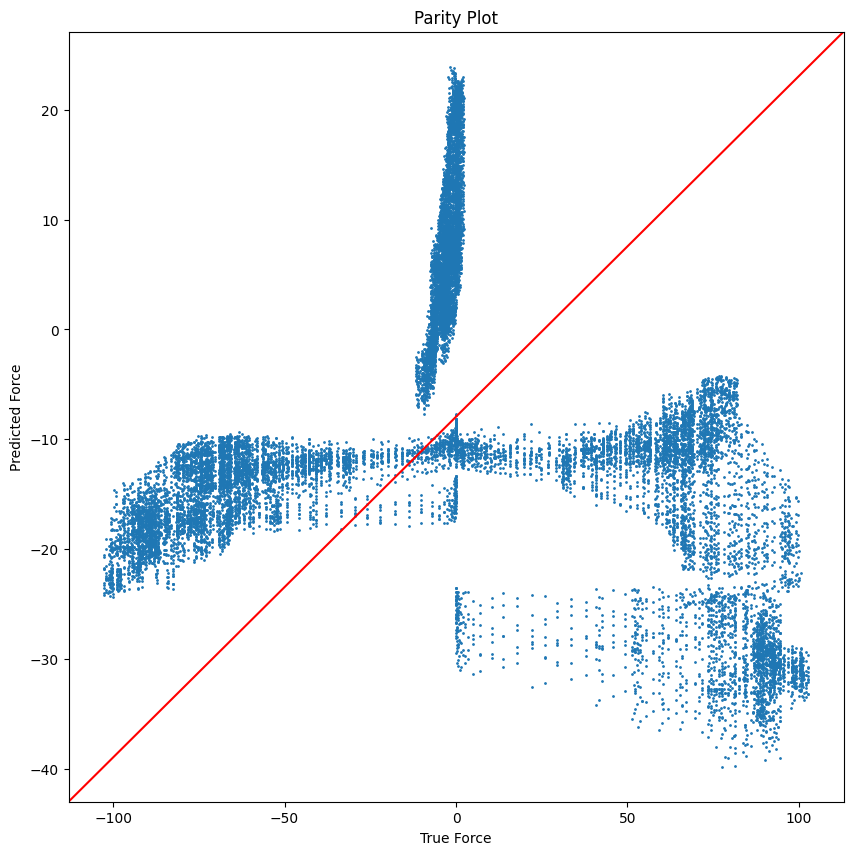

In [140]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [151]:
def TLLSTM(model, X, change_layers=1):
    new = lstm(n_linear_layers=model.n_linear_layers, n_outputs=model.output.out_features, lstm_n_outputs=model.lstm_n_outputs, layer_size=model.layer_size)
    test = new(X)
    new.load_state_dict(model.state_dict())
    children = [child for child in new.children()]
    for child in children:
        for param in child.parameters():
            param.requires_grad = False
    total_layers = len(children)
    for i in range(change_layers):
        layer = children[total_layers-i-1]
        layer_params = layer.parameters()
        for p in layer_params:
            p.requires_grad = True
    return new


In [152]:
model.__dir__()[-40:-1]

['fcs',
 'float',
 'forward',
 'get_buffer',
 'get_extra_state',
 'get_parameter',
 'get_submodule',
 'half',
 'ipu',
 'layer_size',
 'load_state_dict',
 'lstm',
 'lstm_n_outputs',
 'modules',
 'n_linear_layers',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'output',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forward_pre_hook',
 'register_full_backward_hook',
 'register_load_state_dict_post_hook',
 'register_module',
 'register_parameter',
 'requires_grad_',
 'set_extra_state',
 'share_memory',
 'state_dict',
 'to',
 'to_empty',
 'train',
 'training',
 'type',
 'xpu']

In [185]:

tlm = TLLSTM(model, train_data.X[0:10].to('cpu'), change_layers=2)

In [186]:
X_train = train_data.X.to('cuda')
Y_train = train_data.Y.to('cuda')
X_test = test_data.X.to('cuda')
Y_test = test_data.Y.to('cuda')

In [188]:
lr = 1e-3
loss = kmk.run_Pytorch(tlm, X_train, Y_train, n_epochs=201, learning_rate=lr, batch_size=4, optimizer=torch.optim.Adam(tlm.parameters(), lr=lr, weight_decay=1e-3))

EPOCH :  0 , dt:  0.8302037715911865 seconds, losses : 66.1365737915039
EPOCH :  10 , dt:  8.063578844070435 seconds, losses : 46.1760368347168
EPOCH :  20 , dt:  7.88803505897522 seconds, losses : 20.34990692138672
EPOCH :  30 , dt:  8.077396392822266 seconds, losses : 8.349339485168457
EPOCH :  40 , dt:  8.278585195541382 seconds, losses : 7.812546730041504
EPOCH :  50 , dt:  8.852497339248657 seconds, losses : 8.744768142700195
EPOCH :  60 , dt:  8.743759155273438 seconds, losses : 8.682347297668457
EPOCH :  70 , dt:  8.606457471847534 seconds, losses : 9.45681095123291
EPOCH :  80 , dt:  8.749119281768799 seconds, losses : 12.511737823486328
EPOCH :  90 , dt:  8.641087532043457 seconds, losses : 8.251697540283203
EPOCH :  100 , dt:  8.819024324417114 seconds, losses : 10.391130447387695
EPOCH :  110 , dt:  8.518200874328613 seconds, losses : 7.0848894119262695
EPOCH :  120 , dt:  8.64400315284729 seconds, losses : 6.926815032958984
EPOCH :  130 , dt:  8.638848543167114 seconds, los

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

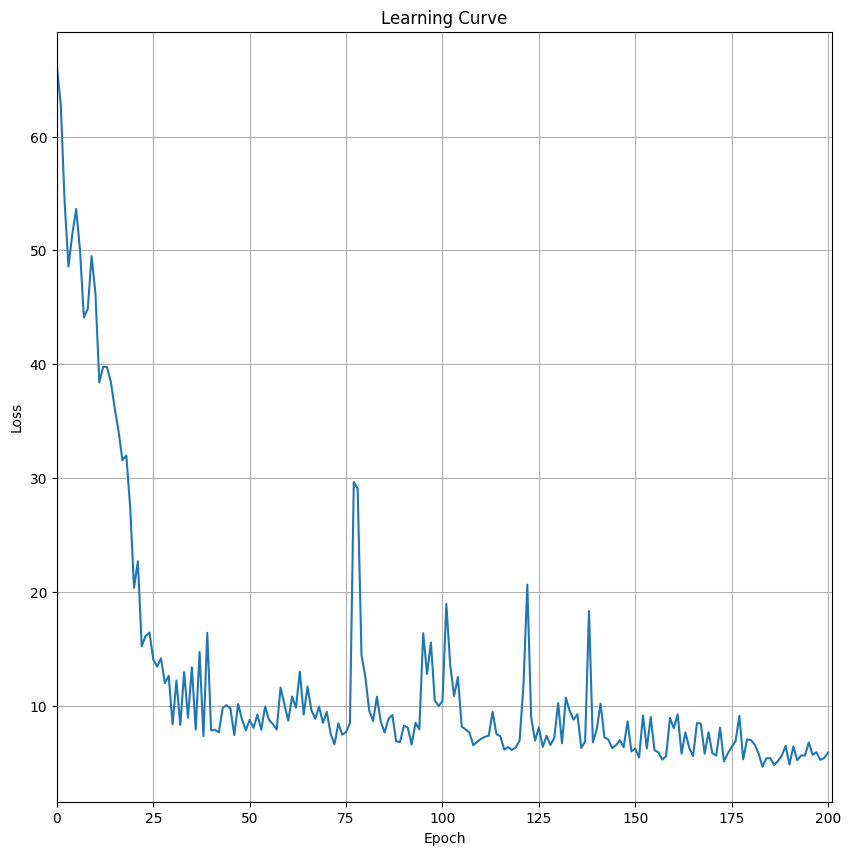

In [189]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    #ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

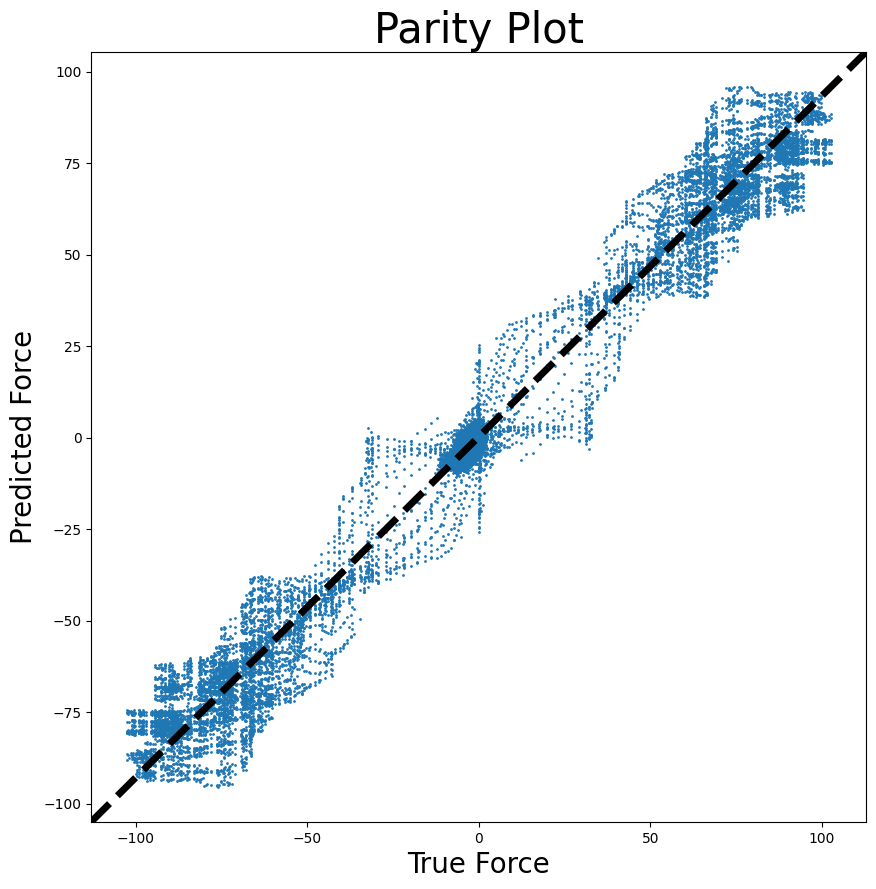

In [197]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force', fontsize=20)
ax.set_ylabel('Predicted Force', fontsize=20)
ax.set_title('Parity Plot', fontsize=30) 
ax.plot([0, 1], [0, 1], '--k', linewidth=5, transform=ax.transAxes)

In [191]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9702089615623155 mae:  7.192872 mse:  95.92553


In [199]:
from datetime import datetime
import os
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    # check if the model already exists and add a number to the end
    if os.path.exists('models/' + name + '.pt'):
        i = 0
        while os.path.exists('models/' + name + str(i) + '.pt'):
            i += 1
        torch.save(model.state_dict(), 'models/' + name + str(i) + '.pt')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'tlm_lstm_3layer_30nodes_200epochs_' + str(datetime.now().date()))

# now with weight_decay

In [94]:
tlm = TLLSTM(model, train_data.X[0:10].to('cpu'), change_layers=2)
loss = kmk.run_Pytorch(tlm, X_train, Y_train, n_epochs=501, learning_rate=1e-3, batch_size=16, optimizer=torch.optim.Adam(tlm.parameters(), lr=1e-3, weight_decay=1e-1))

EPOCH :  0 , dt:  0.4297604560852051 seconds, losses : 611.82177734375
EPOCH :  10 , dt:  3.6400957107543945 seconds, losses : 152.99424743652344
EPOCH :  20 , dt:  3.786773204803467 seconds, losses : 141.65855407714844
EPOCH :  30 , dt:  4.032165288925171 seconds, losses : 132.1738739013672
EPOCH :  40 , dt:  3.8250985145568848 seconds, losses : 121.2171401977539
EPOCH :  50 , dt:  3.703336715698242 seconds, losses : 109.88398742675781
EPOCH :  60 , dt:  3.753077268600464 seconds, losses : 92.85969543457031
EPOCH :  70 , dt:  3.7552661895751953 seconds, losses : 71.3393325805664
EPOCH :  80 , dt:  3.736405849456787 seconds, losses : 54.67155075073242
EPOCH :  90 , dt:  3.7745773792266846 seconds, losses : 44.940608978271484
EPOCH :  100 , dt:  3.7936995029449463 seconds, losses : 39.01485061645508
EPOCH :  110 , dt:  3.7669777870178223 seconds, losses : 32.59498596191406
EPOCH :  120 , dt:  3.735107660293579 seconds, losses : 27.77573585510254
EPOCH :  130 , dt:  3.826242446899414 sec

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

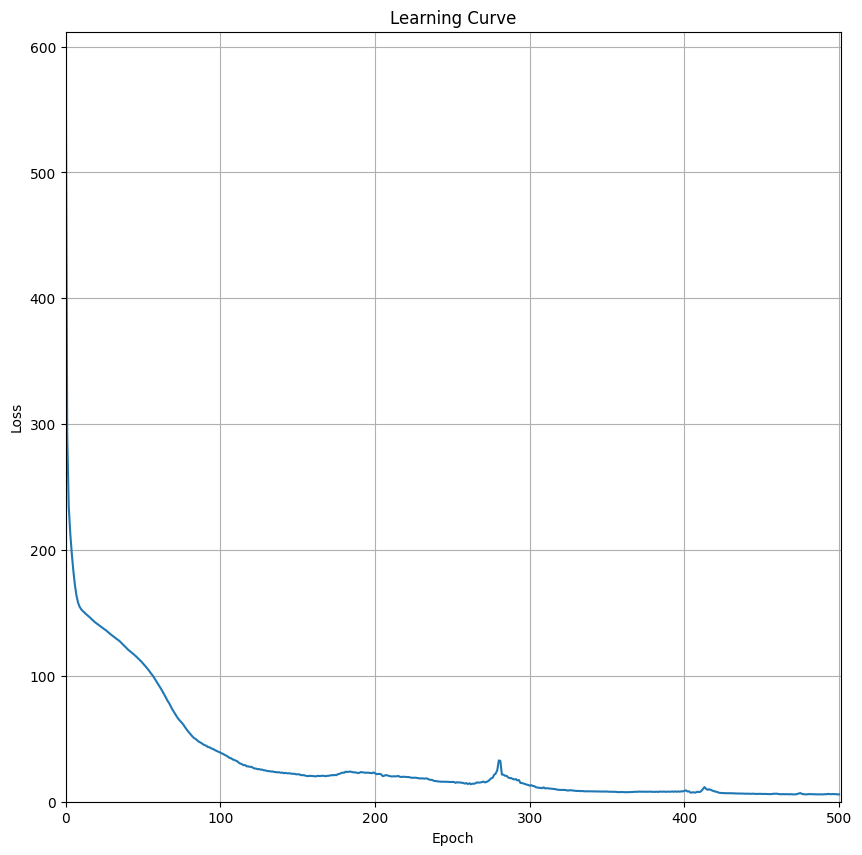

In [97]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

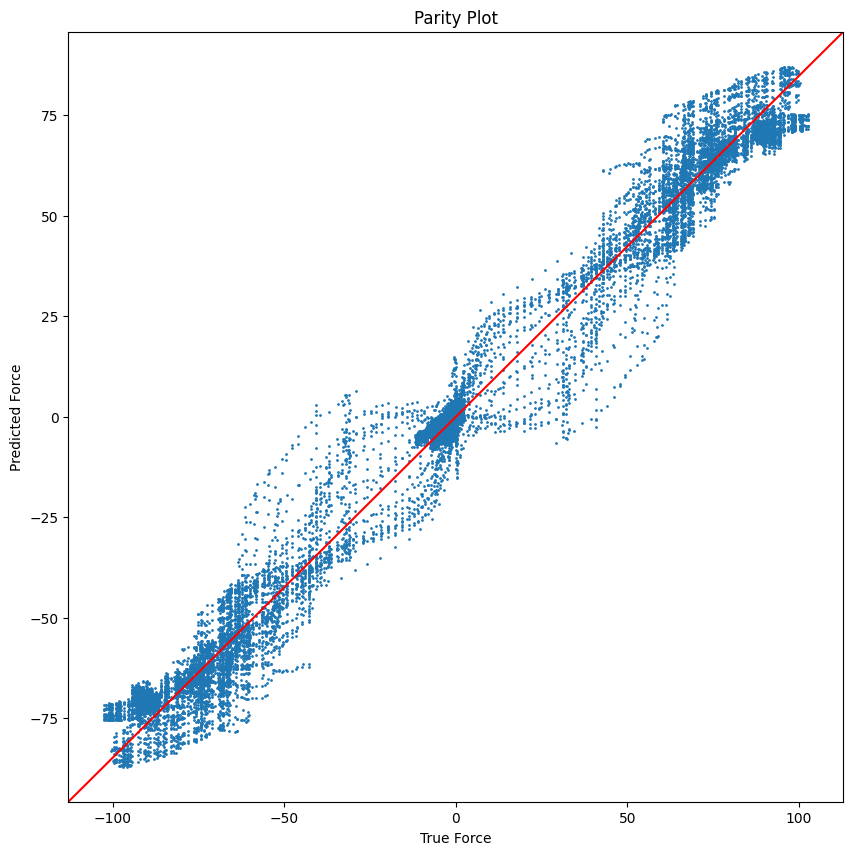

In [98]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [99]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9572793208197238 mae:  8.780775 mse:  137.55827


In [114]:
# retrain the whole model
from copy import copy
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model(train_data.X[0:10].to('cuda')).shape
model.load_state_dict(torch.load('.\models\lstm_3layer_30nodes_200epochs_2023-02-08.pt'))
model_retrain = copy(model)
model_retrain.to('cuda')
loss = kmk.run_Pytorch(model_retrain, X_train, Y_train, n_epochs=501, learning_rate=1e-3, batch_size=16)#, optimizer=torch.optim.Adam(model_retrain.parameters(), lr=1e-3, weight_decay=1e-1))

EPOCH :  0 , dt:  0.5953679084777832 seconds, losses : 341.7650451660156
EPOCH :  10 , dt:  5.102904319763184 seconds, losses : 79.90721893310547
EPOCH :  20 , dt:  4.836278915405273 seconds, losses : 69.3611068725586
EPOCH :  30 , dt:  4.756120920181274 seconds, losses : 48.009681701660156
EPOCH :  40 , dt:  4.93293023109436 seconds, losses : 27.811323165893555
EPOCH :  50 , dt:  4.845363140106201 seconds, losses : 27.762048721313477
EPOCH :  60 , dt:  4.82325553894043 seconds, losses : 21.59133529663086
EPOCH :  70 , dt:  5.04416298866272 seconds, losses : 20.532039642333984
EPOCH :  80 , dt:  5.100178480148315 seconds, losses : 47.86150360107422
EPOCH :  90 , dt:  5.058196306228638 seconds, losses : 27.89307975769043
EPOCH :  100 , dt:  5.831441164016724 seconds, losses : 22.657848358154297
EPOCH :  110 , dt:  6.282247543334961 seconds, losses : 20.752370834350586
EPOCH :  120 , dt:  5.2395339012146 seconds, losses : 56.47473907470703
EPOCH :  130 , dt:  6.042540073394775 seconds, l

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Learning Curve'}, xlabel='Epoch', ylabel='Loss'>)

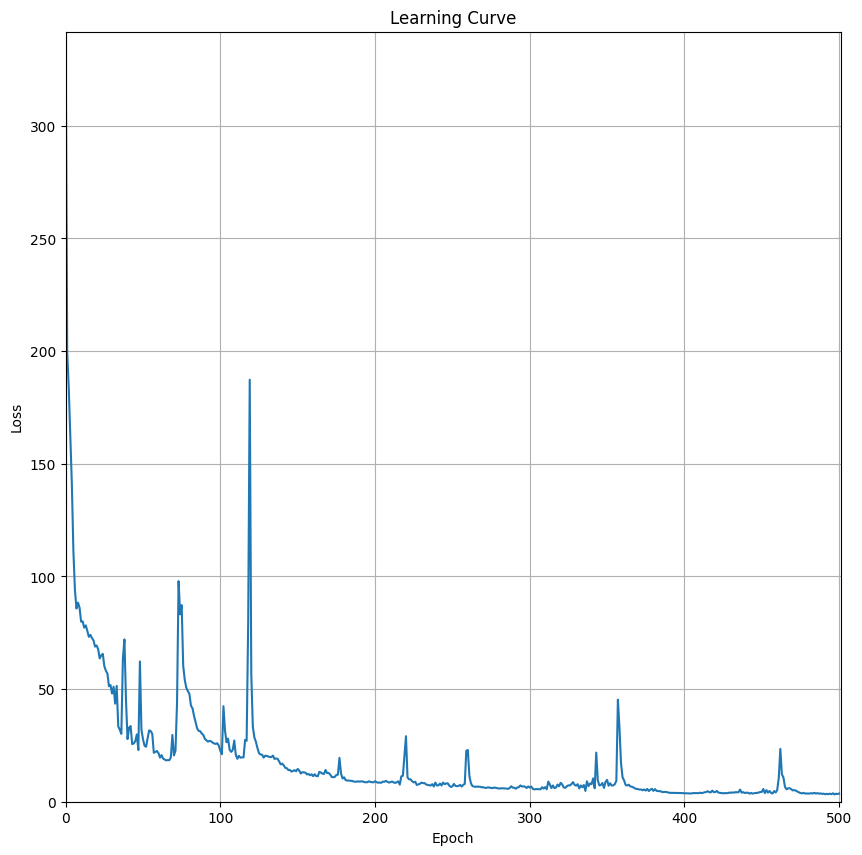

In [115]:
# now to plot a paper worthy learning curve of the model. Make the line stand out in a clean cartoonish way
def plot_learning_curve(losses, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(losses)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses))
    ax.grid()
    return fig, ax
plot_learning_curve(loss, title='Learning Curve', xlabel='Epoch', ylabel='Loss', figsize=(10,10))

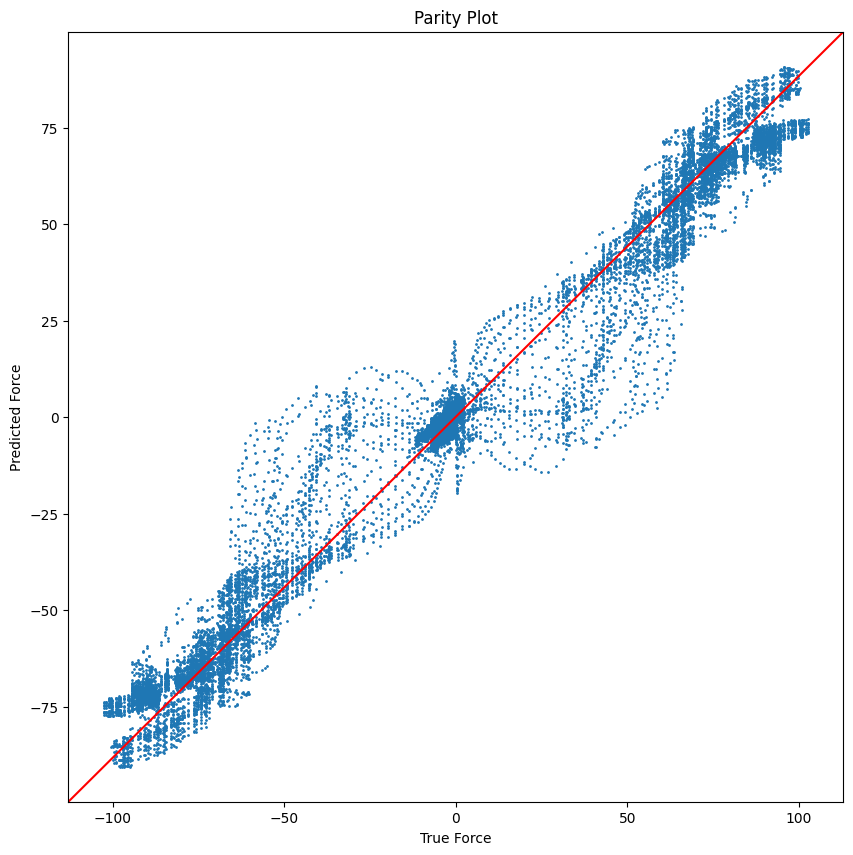

In [116]:
# test the model on the test data. I dont expect this to work well because the model was only on simulated data
import gc
pred = batch_predict(tlm, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [117]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mae = mean_absolute_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
mse = mean_squared_error(test_data.Y.flatten().detach().cpu().numpy(), pred.flatten().detach().cpu().numpy())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9503271996169581 mae:  9.074715 mse:  159.94374
